# Kaggle Competition: Predicting Titanic Survival

In [1]:
#Package Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#read train and holdout
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#functions for data analysis
def process_alone(df):
    #determines if the person was alone
    df['Alone'] = 1
    df.loc[(df['SibSp']>=1) | (df['Parch']>=1),'Alone'] = 0
    df = df.drop(['SibSp', 'Parch'], axis = 1)
    return df

def process_missing(df):
    #Handle various missing values from the data set
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    #Process the Age column into pre-defined 'bins' 
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    df = df.drop('Age',axis=1)
    return df

def process_fare(df):
    #Process the Fare column into pre-defined 'bins' 
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    df = df.drop('Fare',axis=1)
    return df

def process_cabin(df):
    #Process the Cabin column into pre-defined 'bins' 
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    #Extract and categorize the title from the name column 
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    df = df.drop(['Name', 'Sex'], axis = 1)
    return df

def create_dummies(df,column_name):
    #Create Dummy Columns (One Hot Encoding) from a single Column
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
#function to clean data frames
def feature_prepare(df):
    #converts the columns in the titanic data set into
    #useable features
    
    #handle missing values
    df = process_missing(df)
    
    #handle alone
    df = process_alone(df)
    
    #convert age to categories
    df = process_age(df)
    df = create_dummies(df,"Age_categories")
    
    #convert fare to categories
    df = process_fare(df)
    df = create_dummies(df,"Fare_categories")
    
    #extract cabin type and convert to categories
    df = process_cabin(df)
    df = create_dummies(df,"Cabin_type")
    
    #extract titles of people, and convert to categories
    df = process_titles(df)
    df = create_dummies(df,"Title")
    
    return df

In [7]:
#functions for modeling
def best_feature_selection(df, features, target):
    #returns the best features for regression
    
    #extract data
    xs = df[features]
    ys = df[target]
    
    #instatiate classifier
    rfc = RandomForestClassifier(random_state=6, n_estimators=10)
    
    #instatiate recursive feature elimination with cross validation
    selection = RFECV(rfc, cv=10)
    selection.fit(xs, ys) #fit
    
    #extract best features
    return list(xs.columns[selection.support_])

def best_model_selection(df, features, target):
    #returns the best model for classification
    
    #extract data
    xs = df[features]
    ys = df[target]
    
    models = [
        {
            "name": "LogisticRegression",
            "regressor": LogisticRegression(),
            "hyperparameters": {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "regressor": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p":[1,2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "regressor": RandomForestClassifier(),
            "hyperparameters": {
                "n_estimators": [4,6,9,13],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    for model in models:
        print(model['name'])
        print("*"*len(model['name']))
        
        grid = GridSearchCV(
            model['regressor'],
            param_grid=model['hyperparameters'],
            cv = 10,
            iid=True
        )
        
        grid.fit(xs, ys)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        
        print(model["best_params"])
        print(model["best_score"])
        print()
    return models

def kaggle_submission(df, model, features, filename="titanic_submission.csv"):
    #format the two column dataframe and save as a csv
    pd.DataFrame(
        {
            "PassengerId": df["PassengerId"],
            "Survived": model.predict(df[features])
        }
    ).to_csv(filename, index=False)

# Survival Rate

In [8]:
survival_rate = train['Survived'].sum() / len(train['Survived']) 
print(survival_rate)

0.3838383838383838


Approximately 38% of passengers in the training data set survived

# Examine the SibSp and Parch Columns

SibSp contains the number of Siblings the person had onboard
Parch contains the number of family members the person had onboard


In [9]:
print(train['SibSp'].value_counts())
print()
print(train['Parch'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Text(0, 0.5, 'Survival Rate')

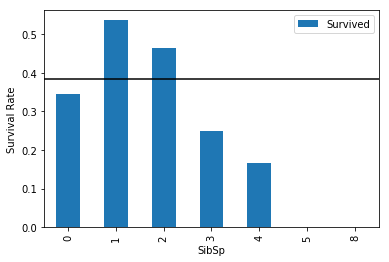

In [10]:
train.pivot_table(values='Survived', index = 'SibSp').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.ylabel("Survival Rate")

Text(0, 0.5, 'Survival Rate')

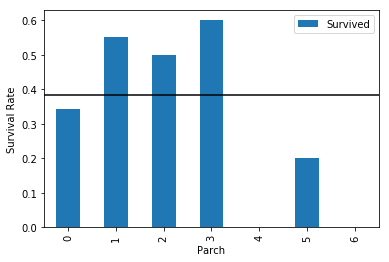

In [11]:
train.pivot_table(values='Survived', index = 'Parch').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.ylabel("Survival Rate")

People with 1 to 3 family members were more likely to survive.
Having a large family on board (4 or more) decreased the likelihood of survival. This may be over-fitting, however, as few people have large families onboard. 

# Examine the Fare column

In [12]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

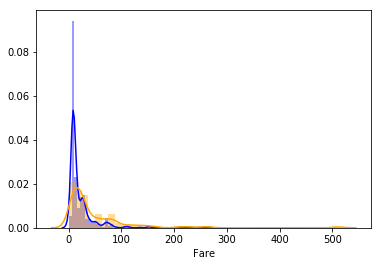

In [13]:
sns.distplot(train.loc[train['Survived']==0, 'Fare'], color='blue')
sns.distplot(train.loc[train['Survived']==1, 'Fare'], color='orange')

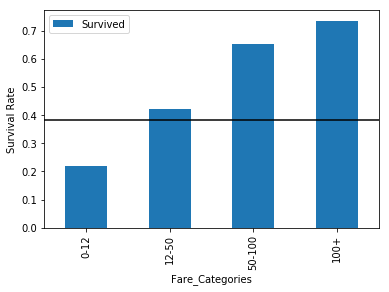

In [14]:
df = train
# I'll use the following bins:
cut_points = [-1,12,50,100,1000]
label_names = [1,2,3,4]
df["Fare_Categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
labels = ["0-12","12-50","50-100","100+"]

#plot
df.pivot_table(values='Survived', index = 'Fare_Categories').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.xticks(np.arange(4), labels)
plt.ylabel("Survival Rate")

del df

# Age column

In [15]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

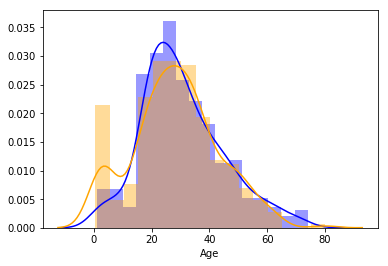

In [16]:
sns.distplot(train.loc[(train['Survived']==0)& (train['Age'].notna()), 'Age'], color='blue')
sns.distplot(train.loc[(train['Survived']==1)& (train['Age'].notna()), 'Age'], color='orange')

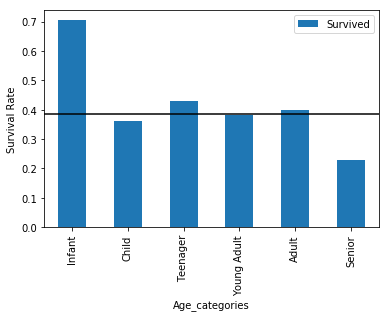

In [17]:
#using the following bins
#survival was biased towards the young
df = train.copy()
df = df[df['Age'].notna()]
cut_points = [0,5,12,18,35,60,100]
label_names = [1,2,3,4,5,6]
df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)

#plot
labels = ["Infant","Child","Teenager","Young Adult","Adult","Senior"]
df.pivot_table(values='Survived', index = 'Age_categories').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.xticks(np.arange(6), labels)
plt.ylabel("Survival Rate")

del df

# Examine the Cabin Column

each cabin number has a letter code followed by a number.
the letter code of the first cabin (if the passenger had multiple) will be extracted.
NaN values will be replaced with "Missing"

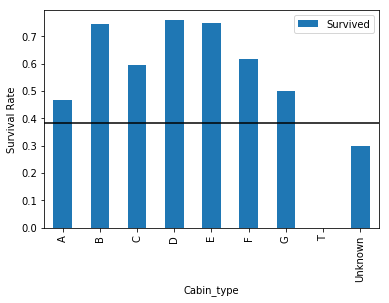

In [18]:
#extract the cabin codes
df = train
df["Cabin_type"] = df["Cabin"].str[0]
df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")

#plot
train.pivot_table(values='Survived', index = 'Cabin_type').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.ylabel("Survival Rate")

del df

# Examine the Title of passenger

each passenger has an honourific that is indicative of their sex and position.
this title is always within the string, and followed by a period
these titles can be extracted by the regex: `' ([A-Za-z]+)\.'`

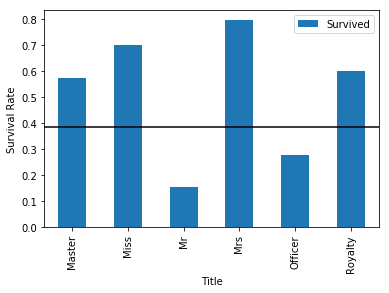

In [19]:
#extract and map titles
df = train
extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
df["Title"] = extracted_titles.map(titles)

#plot
train.pivot_table(values='Survived', index = 'Title').plot.bar()
plt.axhline(y = survival_rate, color='black')
plt.ylabel("Survival Rate")

del df

# Feature Selection and Modeling

In [20]:
#add features and process data frames
train = feature_prepare(train)
holdout = feature_prepare(holdout)

In [21]:
#extract features
features = train.select_dtypes([np.number]).dropna(axis=1).columns.tolist()
features.remove("Survived")
features.remove("PassengerId")
target = 'Survived'
print(features)

['Pclass', 'Alone', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty']


In [22]:
best_features = best_feature_selection(train, features, target)
print(best_features)

['Pclass', 'Alone', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Title_Miss', 'Title_Mr', 'Title_Mrs']


In [23]:
models = best_model_selection(train, best_features, target)

LogisticRegression
******************
{'solver': 'newton-cg'}
0.8069584736251403

KNeighborsClassifier
********************
{'algorithm': 'brute', 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.8204264870931538

RandomForestClassifier
**********************
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 13}
0.8237934904601572



In [24]:
#find the index of the best model
best_score = models[0]["best_score"]
best_index = 0

for i, model in enumerate(models):
    if best_score < model["best_score"]:
        best_score = model["best_score"]
        best_index = i

In [25]:
#generate kaggle submission
kaggle_submission(holdout,
                  models[best_index]["best_estimator"],
                  best_features,
                  filename="titanic_submission.csv")